In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from os.path import join as p_join

import seaborn as sns


##################################
## GLOBAL SETTINGS ###############
##################################
plt.rcParams["figure.figsize"] = (12,8)

In [2]:
### Install CPU torch
# ! pip3 install torch==1.10.2+cpu torchvision==0.11.3+cpu torchaudio==0.10.2+cpu -f https://download.pytorch.org/whl/cpu/torch_stable.html
    
### Inctall GPU torch (CUDA 11.3)
# ! pip3 install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio==0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [3]:
###############################
##### IMPORT DL Depensies #####
###############################
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader

from tqdm import tqdm


def seed_all(seed=42):

    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print("[ Using Seed : ", seed, " ]")

####################################
#####   SEED ALL EXPERIMENTS   #####
####################################
seed_all()    


#################################
####### GLOBAL CONFIG ###########
#################################
CONFIG = {'ephs': 5,
          'train_batch_size': 32,
          'test_batch_size': 16,
          'cpu_workers': 2,
          'save_ckpts': True}

[ Using Seed :  42  ]


In [4]:
import sys
sys.path.append("../..") # Adds higher directory to python modules path.
from utils import utils

In [5]:
data_path = p_join('..', '..', 'data_2')
FOLDERS = [p_join(os.path.abspath(data_path), item) for item in os.listdir(data_path) if 'L=6.6' in item]
FOLDERS

['/home/akhorkin/Repositories/ml_dl_with_topology_data/data_2/N2=27_L=6.6_input=2',
 '/home/akhorkin/Repositories/ml_dl_with_topology_data/data_2/N2=21_L=6.6_input=-4',
 '/home/akhorkin/Repositories/ml_dl_with_topology_data/data_2/N2=21_L=6.6_input=-2',
 '/home/akhorkin/Repositories/ml_dl_with_topology_data/data_2/N2=27_L=6.6_input=-2',
 '/home/akhorkin/Repositories/ml_dl_with_topology_data/data_2/N2=25_L=6.6_input=4',
 '/home/akhorkin/Repositories/ml_dl_with_topology_data/data_2/N2=21_L=6.6_input=2',
 '/home/akhorkin/Repositories/ml_dl_with_topology_data/data_2/N2=23_L=6.6_input=-4',
 '/home/akhorkin/Repositories/ml_dl_with_topology_data/data_2/N2=27_L=6.6_input=-4',
 '/home/akhorkin/Repositories/ml_dl_with_topology_data/data_2/N2=23_L=6.6_input=4',
 '/home/akhorkin/Repositories/ml_dl_with_topology_data/data_2/N2=25_L=6.6_input=-2',
 '/home/akhorkin/Repositories/ml_dl_with_topology_data/data_2/N2=21_L=6.6_input=4',
 '/home/akhorkin/Repositories/ml_dl_with_topology_data/data_2/N2=25_L=

### Create dataset

In [8]:
X, Y = utils.create_dataset(FOLDERS)
X = utils.normalize_data(X)
X = np.expand_dims(X, axis=1)

#################################
#### MAKE TEST TRAIN SPLIT   ####
#################################
def create_dataloaders(CONFIG, X, Y):
    from sklearn.model_selection import train_test_split

    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.2, random_state=42)


    train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(Y_train))
    test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(Y_test))

    train_dataloader = DataLoader(train_dataset,
                                  shuffle=True,
                                  num_workers=CONFIG['cpu_workers'],
                                  batch_size=CONFIG['train_batch_size'],
                                  drop_last=True)

    test_dataloader = DataLoader(test_dataset,
                                 shuffle=False,
                                 num_workers=CONFIG['cpu_workers'],
                                 batch_size=CONFIG['test_batch_size'],
                                 drop_last=False)

    return train_dataloader, test_dataloader

100%|███████████████████████████████████████████| 16/16 [00:01<00:00, 14.80it/s]


### Define base model

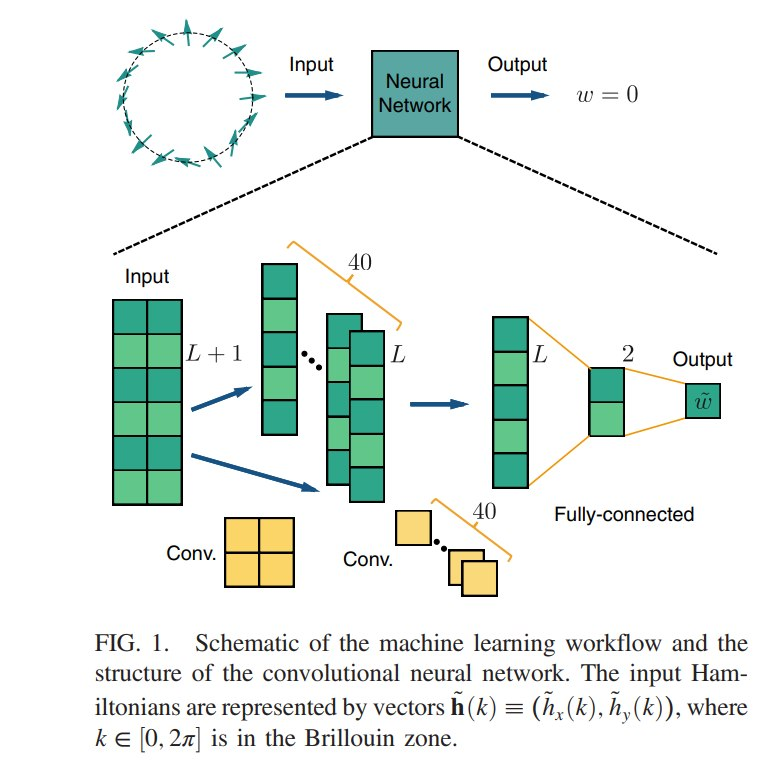

In [17]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.h_dim = 15
        self.activ = F.gelu
        self.conv1 = nn.Conv1d(1, 40, 2)
        self.conv2 = nn.Conv1d(40, 1, 1)
        self.flat = nn.Flatten()
        self.lin = nn.Sequential(nn.Linear(self.h_dim, self.h_dim // 2),
                                 nn.Tanh(), nn.Linear(self.h_dim // 2, 4))

    def forward(self, x):
        x = self.activ(self.conv1(x))
        x = self.activ(self.conv2(x))
        x = self.flat(x)
        x = self.lin(x)
        return x

In [18]:
model = ConvNet()
inp = torch.rand(32, 1, 16)
out = model(inp)
out.shape

torch.Size([32, 1, 15])
torch.Size([32, 15])


torch.Size([32, 4])

### Try training:

In [10]:
CONFIG['train_batch_size'] = 64
CONFIG['ephs'] = 15
net = ConvNet()
optimizer = torch.optim.Adam(net.parameters(), lr=CONFIG.get('lr', 4e-3))
train_dataloader, test_dataloader = create_dataloaders(CONFIG, X, Y)
utils.run_training(net, optimizer, CONFIG, train_dataloader, test_dataloader)

100%|████████████████████████████████████████| 799/799 [00:02<00:00, 274.88it/s]


Epoch: 1/15, 	 total train loss: 1.2816826991354568


100%|████████████████████████████████████████| 800/800 [00:01<00:00, 456.62it/s]


Epoch: 1/15, 	 total score test: 33.1952801437837, [best score: 33.1952801437837]



100%|████████████████████████████████████████| 799/799 [00:02<00:00, 274.01it/s]


Epoch: 2/15, 	 total train loss: 1.2252335151533909


100%|████████████████████████████████████████| 800/800 [00:01<00:00, 442.47it/s]


Epoch: 2/15, 	 total score test: 34.336172540439165, [best score: 34.336172540439165]



100%|████████████████████████████████████████| 799/799 [00:02<00:00, 270.32it/s]


Epoch: 3/15, 	 total train loss: 1.2142073963401614


100%|████████████████████████████████████████| 800/800 [00:01<00:00, 449.43it/s]


Epoch: 3/15, 	 total score test: 34.25802922559975, [best score: 34.336172540439165]



100%|████████████████████████████████████████| 799/799 [00:03<00:00, 241.19it/s]


Epoch: 4/15, 	 total train loss: 1.2075346266671325


100%|████████████████████████████████████████| 800/800 [00:01<00:00, 427.52it/s]


Epoch: 4/15, 	 total score test: 35.000390716574195, [best score: 35.000390716574195]



100%|████████████████████████████████████████| 799/799 [00:03<00:00, 264.35it/s]


Epoch: 5/15, 	 total train loss: 1.2028067716221338


100%|████████████████████████████████████████| 800/800 [00:01<00:00, 441.99it/s]


Epoch: 5/15, 	 total score test: 34.375244197858876, [best score: 35.000390716574195]



100%|████████████████████████████████████████| 799/799 [00:03<00:00, 241.40it/s]


Epoch: 6/15, 	 total train loss: 1.1996682389955198


100%|████████████████████████████████████████| 800/800 [00:01<00:00, 461.80it/s]


Epoch: 6/15, 	 total score test: 35.01601937954208, [best score: 35.01601937954208]



100%|████████████████████████████████████████| 799/799 [00:03<00:00, 261.06it/s]


Epoch: 7/15, 	 total train loss: 1.1974407004772945


100%|████████████████████████████████████████| 800/800 [00:01<00:00, 433.73it/s]


Epoch: 7/15, 	 total score test: 34.609674142377116, [best score: 35.01601937954208]



100%|████████████████████████████████████████| 799/799 [00:03<00:00, 262.89it/s]


Epoch: 8/15, 	 total train loss: 1.194767227459312


100%|████████████████████████████████████████| 800/800 [00:01<00:00, 424.54it/s]


Epoch: 8/15, 	 total score test: 34.41431585527858, [best score: 35.01601937954208]



100%|████████████████████████████████████████| 799/799 [00:03<00:00, 253.14it/s]


Epoch: 9/15, 	 total train loss: 1.1926874759349417


100%|████████████████████████████████████████| 800/800 [00:01<00:00, 430.98it/s]


Epoch: 9/15, 	 total score test: 34.84410408689536, [best score: 35.01601937954208]



100%|████████████████████████████████████████| 799/799 [00:02<00:00, 272.06it/s]


Epoch: 10/15, 	 total train loss: 1.190288005991185


100%|████████████████████████████████████████| 800/800 [00:01<00:00, 458.64it/s]


Epoch: 10/15, 	 total score test: 35.10197702586544, [best score: 35.10197702586544]



100%|████████████████████████████████████████| 799/799 [00:02<00:00, 267.49it/s]


Epoch: 11/15, 	 total train loss: 1.188335993710686


100%|████████████████████████████████████████| 800/800 [00:01<00:00, 445.02it/s]


Epoch: 11/15, 	 total score test: 35.602094240837694, [best score: 35.602094240837694]



100%|████████████████████████████████████████| 799/799 [00:02<00:00, 271.01it/s]


Epoch: 12/15, 	 total train loss: 1.1873606012222615


100%|████████████████████████████████████████| 800/800 [00:01<00:00, 463.38it/s]


Epoch: 12/15, 	 total score test: 34.70344612018442, [best score: 35.602094240837694]



100%|████████████████████████████████████████| 799/799 [00:02<00:00, 277.52it/s]


Epoch: 13/15, 	 total train loss: 1.1865322031873338


100%|████████████████████████████████████████| 800/800 [00:01<00:00, 468.20it/s]


Epoch: 13/15, 	 total score test: 35.391107290771274, [best score: 35.602094240837694]



100%|████████████████████████████████████████| 799/799 [00:03<00:00, 265.29it/s]


Epoch: 14/15, 	 total train loss: 1.183716924676907


100%|████████████████████████████████████████| 800/800 [00:01<00:00, 473.39it/s]


Epoch: 14/15, 	 total score test: 35.29733531296397, [best score: 35.602094240837694]



100%|████████████████████████████████████████| 799/799 [00:02<00:00, 274.32it/s]


Epoch: 15/15, 	 total train loss: 1.1827080307973639


100%|████████████████████████████████████████| 800/800 [00:01<00:00, 470.26it/s]

Epoch: 15/15, 	 total score test: 34.87536141283113, [best score: 35.602094240837694]



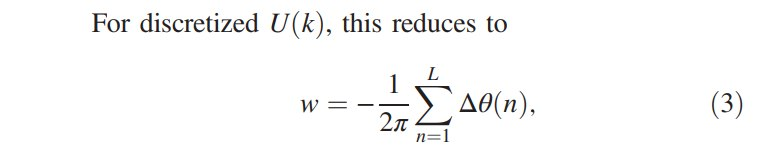

### Try global Avg pool

In [53]:
class ConvNet2(nn.Module):
    def __init__(self):
        super().__init__()
        self.h_dim = 15
        self.activ = F.gelu
        self.conv1 = nn.Conv1d(1, 40, 2)
        self.conv2 = nn.Conv1d(40, 15, 3, padding='same')
        self.global_avg = nn.AdaptiveAvgPool1d(1)
        self.flat = nn.Flatten()
        self.lin = nn.Sequential(nn.Linear(self.h_dim, self.h_dim // 2),
                                 nn.Tanh(), nn.Linear(self.h_dim // 2, 4))

    def forward(self, x):
        x = self.activ(self.conv1(x))
        x = self.activ(self.conv2(x))
        x = self.global_avg(x)
        x = self.flat(x)
        x = self.lin(x)
        return x

In [54]:
model = ConvNet2()
inp = torch.rand(32, 1, 16)
out = model(inp)
out.shape

torch.Size([32, 4])

In [55]:
CONFIG['train_batch_size'] = 64
CONFIG['ephs'] = 15
net = ConvNet2()
optimizer = torch.optim.Adam(net.parameters(), lr=CONFIG.get('lr', 4e-3))
train_dataloader, test_dataloader = create_dataloaders(CONFIG, X, Y)
utils.run_training(net, optimizer, CONFIG, train_dataloader, test_dataloader)

100%|████████████████████████████████████████| 799/799 [00:03<00:00, 216.14it/s]


Epoch: 1/15, 	 total train loss: 1.3688556282630702


100%|████████████████████████████████████████| 800/800 [00:01<00:00, 424.52it/s]


Epoch: 1/15, 	 total score test: 32.01531608970853, [best score: 32.01531608970853]



100%|████████████████████████████████████████| 799/799 [00:03<00:00, 224.76it/s]


Epoch: 2/15, 	 total train loss: 1.250132457932483


100%|████████████████████████████████████████| 800/800 [00:01<00:00, 418.48it/s]


Epoch: 2/15, 	 total score test: 35.336406970383685, [best score: 35.336406970383685]



100%|████████████████████████████████████████| 799/799 [00:03<00:00, 229.52it/s]


Epoch: 3/15, 	 total train loss: 1.2083056295320895


100%|████████████████████████████████████████| 800/800 [00:02<00:00, 399.58it/s]


Epoch: 3/15, 	 total score test: 36.813315620848634, [best score: 36.813315620848634]



100%|████████████████████████████████████████| 799/799 [00:03<00:00, 227.31it/s]


Epoch: 4/15, 	 total train loss: 1.1895999162456719


100%|████████████████████████████████████████| 800/800 [00:02<00:00, 385.50it/s]


Epoch: 4/15, 	 total score test: 38.38399624912089, [best score: 38.38399624912089]



100%|████████████████████████████████████████| 799/799 [00:03<00:00, 222.94it/s]


Epoch: 5/15, 	 total train loss: 1.1792143725035933


100%|████████████████████████████████████████| 800/800 [00:01<00:00, 414.28it/s]


Epoch: 5/15, 	 total score test: 38.516839884347895, [best score: 38.516839884347895]



100%|████████████████████████████████████████| 799/799 [00:03<00:00, 224.17it/s]


Epoch: 6/15, 	 total train loss: 1.1722210383086986


100%|████████████████████████████████████████| 800/800 [00:01<00:00, 419.09it/s]


Epoch: 6/15, 	 total score test: 38.58716886770337, [best score: 38.58716886770337]



100%|████████████████████████████████████████| 799/799 [00:03<00:00, 233.95it/s]


Epoch: 7/15, 	 total train loss: 1.1659200163896153


100%|████████████████████████████████████████| 800/800 [00:01<00:00, 448.03it/s]


Epoch: 7/15, 	 total score test: 39.14198640306322, [best score: 39.14198640306322]



100%|████████████████████████████████████████| 799/799 [00:03<00:00, 241.47it/s]


Epoch: 8/15, 	 total train loss: 1.160249250030637


100%|████████████████████████████████████████| 800/800 [00:01<00:00, 442.07it/s]


Epoch: 8/15, 	 total score test: 39.82964757365007, [best score: 39.82964757365007]



100%|████████████████████████████████████████| 799/799 [00:03<00:00, 237.41it/s]


Epoch: 9/15, 	 total train loss: 1.155105835206816


100%|████████████████████████████████████████| 800/800 [00:01<00:00, 450.97it/s]


Epoch: 9/15, 	 total score test: 39.024771430804094, [best score: 39.82964757365007]



100%|████████████████████████████████████████| 799/799 [00:03<00:00, 239.27it/s]


Epoch: 10/15, 	 total train loss: 1.15177789684828


100%|████████████████████████████████████████| 800/800 [00:01<00:00, 440.28it/s]


Epoch: 10/15, 	 total score test: 40.087520512620145, [best score: 40.087520512620145]



100%|████████████████████████████████████████| 799/799 [00:03<00:00, 239.83it/s]


Epoch: 11/15, 	 total train loss: 1.1475778539130028


100%|████████████████████████████████████████| 800/800 [00:01<00:00, 428.14it/s]


Epoch: 11/15, 	 total score test: 39.7593185902946, [best score: 40.087520512620145]



100%|████████████████████████████████████████| 799/799 [00:03<00:00, 205.70it/s]


Epoch: 12/15, 	 total train loss: 1.1421907403143834


100%|████████████████████████████████████████| 800/800 [00:01<00:00, 429.87it/s]


Epoch: 12/15, 	 total score test: 39.90779088848949, [best score: 40.087520512620145]



100%|████████████████████████████████████████| 799/799 [00:03<00:00, 241.97it/s]


Epoch: 13/15, 	 total train loss: 1.1390331465102854


100%|████████████████████████████████████████| 800/800 [00:01<00:00, 434.17it/s]


Epoch: 13/15, 	 total score test: 40.79081034617489, [best score: 40.79081034617489]



100%|████████████████████████████████████████| 799/799 [00:04<00:00, 199.36it/s]


Epoch: 14/15, 	 total train loss: 1.1354027994732385


100%|████████████████████████████████████████| 800/800 [00:02<00:00, 378.46it/s]


Epoch: 14/15, 	 total score test: 41.3768852074705, [best score: 41.3768852074705]



100%|████████████████████████████████████████| 799/799 [00:03<00:00, 215.47it/s]


Epoch: 15/15, 	 total train loss: 1.1311445524904398


100%|████████████████████████████████████████| 800/800 [00:01<00:00, 448.47it/s]

Epoch: 15/15, 	 total score test: 40.056263186684376, [best score: 41.3768852074705]



In [56]:
class ConvNet2(nn.Module):
    def __init__(self):
        super().__init__()
        self.h_dim = 240
        self.activ = F.gelu
        self.conv1 = nn.Conv1d(1, 40, 2, padding='same')
        self.conv2 = nn.Conv1d(40, 15, 3, padding='same')
        self.flat = nn.Flatten()
        self.lin = nn.Sequential(nn.Linear(self.h_dim, self.h_dim // 2),
                                 nn.Tanh(), nn.Linear(self.h_dim // 2, 4))

    def forward(self, x):
        x = self.activ(self.conv1(x))
        x = self.activ(self.conv2(x))
        x = self.flat(x)
        x = self.lin(x)
        return x

model = ConvNet2()
inp = torch.rand(32, 1, 16)
out = model(inp)
out.shape

CONFIG['train_batch_size'] = 64
CONFIG['ephs'] = 15
net = ConvNet2()
optimizer = torch.optim.Adam(net.parameters(), lr=CONFIG.get('lr', 4e-3))
train_dataloader, test_dataloader = create_dataloaders(CONFIG, X, Y)
utils.run_training(net, optimizer, CONFIG, train_dataloader, test_dataloader)

100%|████████████████████████████████████████| 799/799 [00:04<00:00, 194.02it/s]


Epoch: 1/15, 	 total train loss: 1.191711413547005


100%|████████████████████████████████████████| 800/800 [00:01<00:00, 430.64it/s]


Epoch: 1/15, 	 total score test: 39.53270297726029, [best score: 39.53270297726029]



100%|████████████████████████████████████████| 799/799 [00:04<00:00, 185.50it/s]


Epoch: 2/15, 	 total train loss: 1.094385907557491


100%|████████████████████████████████████████| 800/800 [00:02<00:00, 378.11it/s]


Epoch: 2/15, 	 total score test: 45.28405094944127, [best score: 45.28405094944127]



100%|████████████████████████████████████████| 799/799 [00:04<00:00, 189.09it/s]


Epoch: 3/15, 	 total train loss: 0.9879846594509702


100%|████████████████████████████████████████| 800/800 [00:02<00:00, 390.53it/s]


Epoch: 3/15, 	 total score test: 50.285223099163865, [best score: 50.285223099163865]



100%|████████████████████████████████████████| 799/799 [00:04<00:00, 196.31it/s]


Epoch: 4/15, 	 total train loss: 0.8953234096790882


100%|████████████████████████████████████████| 800/800 [00:01<00:00, 401.97it/s]


Epoch: 4/15, 	 total score test: 55.20825193404704, [best score: 55.20825193404704]



100%|████████████████████████████████████████| 799/799 [00:04<00:00, 183.20it/s]


Epoch: 5/15, 	 total train loss: 0.825958690520968


100%|████████████████████████████████████████| 800/800 [00:01<00:00, 437.98it/s]


Epoch: 5/15, 	 total score test: 57.185277799484254, [best score: 57.185277799484254]



100%|████████████████████████████████████████| 799/799 [00:03<00:00, 203.12it/s]


Epoch: 6/15, 	 total train loss: 0.7886432786011726


100%|████████████████████████████████████████| 800/800 [00:01<00:00, 434.47it/s]


Epoch: 6/15, 	 total score test: 56.943033523482065, [best score: 57.185277799484254]



100%|████████████████████████████████████████| 799/799 [00:03<00:00, 206.32it/s]


Epoch: 7/15, 	 total train loss: 0.7618755087983773


100%|████████████████████████████████████████| 800/800 [00:01<00:00, 415.09it/s]


Epoch: 7/15, 	 total score test: 58.849730405563804, [best score: 58.849730405563804]



100%|████████████████████████████████████████| 799/799 [00:04<00:00, 188.80it/s]


Epoch: 8/15, 	 total train loss: 0.7439037538290919


100%|████████████████████████████████████████| 800/800 [00:02<00:00, 390.55it/s]


Epoch: 8/15, 	 total score test: 58.6621864499492, [best score: 58.849730405563804]



100%|████████████████████████████████████████| 799/799 [00:04<00:00, 192.27it/s]


Epoch: 9/15, 	 total train loss: 0.727555126585859


100%|████████████████████████████████████████| 800/800 [00:01<00:00, 433.16it/s]


Epoch: 9/15, 	 total score test: 59.302961631632414, [best score: 59.302961631632414]



100%|████████████████████████████████████████| 799/799 [00:04<00:00, 193.62it/s]


Epoch: 10/15, 	 total train loss: 0.7170378576232137


100%|████████████████████████████████████████| 800/800 [00:01<00:00, 434.76it/s]


Epoch: 10/15, 	 total score test: 60.0531374540908, [best score: 60.0531374540908]



100%|████████████████████████████████████████| 799/799 [00:04<00:00, 196.38it/s]


Epoch: 11/15, 	 total train loss: 0.7093171118496356


100%|████████████████████████████████████████| 800/800 [00:01<00:00, 421.80it/s]


Epoch: 11/15, 	 total score test: 60.71735563022583, [best score: 60.71735563022583]



100%|████████████████████████████████████████| 799/799 [00:03<00:00, 201.41it/s]


Epoch: 12/15, 	 total train loss: 0.6962971561617487


100%|████████████████████████████████████████| 800/800 [00:01<00:00, 413.23it/s]


Epoch: 12/15, 	 total score test: 61.029928889583495, [best score: 61.029928889583495]



100%|████████████████████████████████████████| 799/799 [00:03<00:00, 206.09it/s]


Epoch: 13/15, 	 total train loss: 0.6905543874291813


100%|████████████████████████████████████████| 800/800 [00:01<00:00, 420.61it/s]


Epoch: 13/15, 	 total score test: 61.60037508791123, [best score: 61.60037508791123]



100%|████████████████████████████████████████| 799/799 [00:04<00:00, 192.25it/s]


Epoch: 14/15, 	 total train loss: 0.6822410278833554


100%|████████████████████████████████████████| 800/800 [00:02<00:00, 388.81it/s]


Epoch: 14/15, 	 total score test: 61.639446745330936, [best score: 61.639446745330936]



100%|████████████████████████████████████████| 799/799 [00:04<00:00, 192.45it/s]


Epoch: 15/15, 	 total train loss: 0.6749400223823304


100%|████████████████████████████████████████| 800/800 [00:01<00:00, 427.19it/s]

Epoch: 15/15, 	 total score test: 60.912713917324375, [best score: 61.639446745330936]



In [58]:
class ConvNet2(nn.Module):
    def __init__(self):
        super().__init__()
        self.h_dim = 240
        self.activ = F.gelu
        self.conv1 = nn.Conv1d(1, 40, 7, padding='same')
        self.conv2 = nn.Conv1d(40, 15, 3, padding='same')
        self.flat = nn.Flatten()
        self.lin = nn.Sequential(nn.Linear(self.h_dim, self.h_dim // 2),
                                 nn.Tanh(), nn.Linear(self.h_dim // 2, 4))

    def forward(self, x):
        x = self.activ(self.conv1(x))
        x = self.activ(self.conv2(x))
        x = self.flat(x)
        x = self.lin(x)
        return x

model = ConvNet2()
inp = torch.rand(32, 1, 16)
out = model(inp)
out.shape

CONFIG['train_batch_size'] = 64
CONFIG['ephs'] = 15
net = ConvNet2()
optimizer = torch.optim.Adam(net.parameters(), lr=CONFIG.get('lr', 4e-3))
train_dataloader, test_dataloader = create_dataloaders(CONFIG, X, Y)
utils.run_training(net, optimizer, CONFIG, train_dataloader, test_dataloader)

100%|████████████████████████████████████████| 799/799 [00:04<00:00, 177.37it/s]


Epoch: 1/15, 	 total train loss: 1.1680903471306954


100%|████████████████████████████████████████| 800/800 [00:01<00:00, 414.84it/s]


Epoch: 1/15, 	 total score test: 41.79885910760334, [best score: 41.79885910760334]



100%|████████████████████████████████████████| 799/799 [00:04<00:00, 191.19it/s]


Epoch: 2/15, 	 total train loss: 1.014128470301479


100%|████████████████████████████████████████| 800/800 [00:01<00:00, 429.60it/s]


Epoch: 2/15, 	 total score test: 50.18363678987263, [best score: 50.18363678987263]



100%|████████████████████████████████████████| 799/799 [00:04<00:00, 175.73it/s]


Epoch: 3/15, 	 total train loss: 0.8977840576362849


100%|████████████████████████████████████████| 800/800 [00:02<00:00, 366.45it/s]


Epoch: 3/15, 	 total score test: 54.73939204501055, [best score: 54.73939204501055]



100%|████████████████████████████████████████| 799/799 [00:04<00:00, 175.34it/s]


Epoch: 4/15, 	 total train loss: 0.8453411205540013


100%|████████████████████████████████████████| 800/800 [00:02<00:00, 388.61it/s]


Epoch: 4/15, 	 total score test: 55.638040165663824, [best score: 55.638040165663824]



100%|████████████████████████████████████████| 799/799 [00:04<00:00, 174.06it/s]


Epoch: 5/15, 	 total train loss: 0.8088591120419126


100%|████████████████████████████████████████| 800/800 [00:01<00:00, 417.82it/s]


Epoch: 5/15, 	 total score test: 56.87270454012659, [best score: 56.87270454012659]



100%|████████████████████████████████████████| 799/799 [00:04<00:00, 183.33it/s]


Epoch: 6/15, 	 total train loss: 0.7828300220796254


100%|████████████████████████████████████████| 800/800 [00:01<00:00, 406.60it/s]


Epoch: 6/15, 	 total score test: 58.732515433304684, [best score: 58.732515433304684]



100%|████████████████████████████████████████| 799/799 [00:04<00:00, 183.00it/s]


Epoch: 7/15, 	 total train loss: 0.7591545733999698


100%|████████████████████████████████████████| 800/800 [00:02<00:00, 387.66it/s]


Epoch: 7/15, 	 total score test: 58.49808548878644, [best score: 58.732515433304684]



100%|████████████████████████████████████████| 799/799 [00:04<00:00, 173.63it/s]


Epoch: 8/15, 	 total train loss: 0.7486469850074663


100%|████████████████████████████████████████| 800/800 [00:02<00:00, 396.34it/s]


Epoch: 8/15, 	 total score test: 59.28733296866453, [best score: 59.28733296866453]



100%|████████████████████████████████████████| 799/799 [00:04<00:00, 171.05it/s]


Epoch: 9/15, 	 total train loss: 0.7333229443009416


100%|████████████████████████████████████████| 800/800 [00:02<00:00, 359.05it/s]


Epoch: 9/15, 	 total score test: 60.45166835977182, [best score: 60.45166835977182]



100%|████████████████████████████████████████| 799/799 [00:04<00:00, 170.59it/s]


Epoch: 10/15, 	 total train loss: 0.7223902631910035


100%|████████████████████████████████████████| 800/800 [00:01<00:00, 406.65it/s]


Epoch: 10/15, 	 total score test: 60.607954989450654, [best score: 60.607954989450654]



100%|████████████████████████████████████████| 799/799 [00:04<00:00, 163.95it/s]


Epoch: 11/15, 	 total train loss: 0.7148988626999909


100%|████████████████████████████████████████| 800/800 [00:02<00:00, 357.20it/s]


Epoch: 11/15, 	 total score test: 60.482925685707585, [best score: 60.607954989450654]



100%|████████████████████████████████████████| 799/799 [00:04<00:00, 187.03it/s]


Epoch: 12/15, 	 total train loss: 0.7033702707633805


100%|████████████████████████████████████████| 800/800 [00:02<00:00, 372.93it/s]


Epoch: 12/15, 	 total score test: 60.631397983902474, [best score: 60.631397983902474]



100%|████████████████████████████████████████| 799/799 [00:04<00:00, 186.47it/s]


Epoch: 13/15, 	 total train loss: 0.6960459009502946


100%|████████████████████████████████████████| 800/800 [00:01<00:00, 421.26it/s]


Epoch: 13/15, 	 total score test: 61.428459795264516, [best score: 61.428459795264516]



100%|████████████████████████████████████████| 799/799 [00:04<00:00, 184.70it/s]


Epoch: 14/15, 	 total train loss: 0.6882758804122557


100%|████████████████████████████████████████| 800/800 [00:01<00:00, 408.66it/s]


Epoch: 14/15, 	 total score test: 61.1627725248105, [best score: 61.428459795264516]



100%|████████████████████████████████████████| 799/799 [00:04<00:00, 164.18it/s]


Epoch: 15/15, 	 total train loss: 0.6836490630357525


100%|████████████████████████████████████████| 800/800 [00:02<00:00, 377.63it/s]

Epoch: 15/15, 	 total score test: 61.576932093459405, [best score: 61.576932093459405]



### Try more layers

In [77]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.drop_p = 0.1
        self.h_dim = 240
        self.h_dims = [1, 32, 64, self.h_dim]
        self.backbone = nn.Sequential(*[Block(self.h_dims[i], self.h_dims[i + 1], 3) for i in range(len(self.h_dims) - 1)])
        self.flat = nn.Flatten()
        self.drop = nn.Dropout(p=self.drop_p)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.lin = nn.Sequential(nn.Linear(self.h_dim, self.h_dim * 2),
                                 nn.BatchNorm1d(self.h_dim * 2),
                                 nn.GELU(),
                                 nn.Dropout(p=self.drop_p),
                                 nn.Linear(self.h_dim * 2, self.h_dim // 2),
                                 nn.BatchNorm1d(self.h_dim // 2),
                                 nn.GELU(),
                                 nn.Dropout(p=self.drop_p),
                                 nn.Linear(self.h_dim // 2, 4))

    def forward(self, x):
        x = self.backbone(x)
        x = self.pool(x)
        x = self.flat(x)
        x = self.drop(x)
#         print(x.shape)
        x = self.lin(x)
        return x
    
model = ConvNet()
inp = torch.rand(32, 1, 16)
out = model(inp)
out.shape

CONFIG['train_batch_size'] = 64
CONFIG['ephs'] = 35
net = ConvNet()
train_dataloader, test_dataloader = create_dataloaders(CONFIG, X, Y)
optimizer = torch.optim.Adam(net.parameters(), lr=CONFIG.get('lr', 1e-3))
utils.run_training(net, optimizer, CONFIG, train_dataloader, test_dataloader)

100%|█████████████████████████████████████████| 799/799 [00:18<00:00, 42.55it/s]


Epoch: 1/35, 	 total train loss: 1.1922730202967293


100%|████████████████████████████████████████| 800/800 [00:05<00:00, 135.96it/s]


Epoch: 1/35, 	 total score test: 40.06407751816832, [best score: 40.06407751816832]



100%|█████████████████████████████████████████| 799/799 [00:22<00:00, 36.13it/s]


Epoch: 2/35, 	 total train loss: 1.0911469129059879


100%|████████████████████████████████████████| 800/800 [00:05<00:00, 151.42it/s]


Epoch: 2/35, 	 total score test: 48.073767289208405, [best score: 48.073767289208405]



100%|█████████████████████████████████████████| 799/799 [00:23<00:00, 33.35it/s]


Epoch: 3/35, 	 total train loss: 0.9943827153445782


100%|████████████████████████████████████████| 800/800 [00:05<00:00, 150.89it/s]


Epoch: 3/35, 	 total score test: 52.559193560990856, [best score: 52.559193560990856]



100%|█████████████████████████████████████████| 799/799 [00:23<00:00, 34.04it/s]


Epoch: 4/35, 	 total train loss: 0.9110938634383067


100%|████████████████████████████████████████| 800/800 [00:05<00:00, 158.23it/s]


Epoch: 4/35, 	 total score test: 55.2004376025631, [best score: 55.2004376025631]



100%|█████████████████████████████████████████| 799/799 [00:20<00:00, 39.67it/s]


Epoch: 5/35, 	 total train loss: 0.8525469115887476


100%|████████████████████████████████████████| 800/800 [00:05<00:00, 150.51it/s]


Epoch: 5/35, 	 total score test: 57.87293897007111, [best score: 57.87293897007111]



100%|█████████████████████████████████████████| 799/799 [00:21<00:00, 36.72it/s]


Epoch: 6/35, 	 total train loss: 0.8085659024712439


100%|████████████████████████████████████████| 800/800 [00:06<00:00, 123.23it/s]


Epoch: 6/35, 	 total score test: 58.459013831366725, [best score: 58.459013831366725]



100%|█████████████████████████████████████████| 799/799 [00:25<00:00, 31.48it/s]


Epoch: 7/35, 	 total train loss: 0.7757660259442574


100%|████████████████████████████████████████| 800/800 [00:05<00:00, 150.72it/s]


Epoch: 7/35, 	 total score test: 57.755723997811984, [best score: 58.459013831366725]



100%|█████████████████████████████████████████| 799/799 [00:23<00:00, 34.57it/s]


Epoch: 8/35, 	 total train loss: 0.7567513829775537


100%|████████████████████████████████████████| 800/800 [00:05<00:00, 142.44it/s]


Epoch: 8/35, 	 total score test: 59.74056419473314, [best score: 59.74056419473314]



100%|█████████████████████████████████████████| 799/799 [00:25<00:00, 31.15it/s]


Epoch: 9/35, 	 total train loss: 0.7377709779184363


100%|████████████████████████████████████████| 800/800 [00:05<00:00, 133.95it/s]


Epoch: 9/35, 	 total score test: 61.42064546378057, [best score: 61.42064546378057]



100%|█████████████████████████████████████████| 799/799 [00:23<00:00, 34.65it/s]


Epoch: 10/35, 	 total train loss: 0.7199145365268627


100%|████████████████████████████████████████| 800/800 [00:05<00:00, 136.72it/s]


Epoch: 10/35, 	 total score test: 61.04555755255138, [best score: 61.42064546378057]



100%|█████████████████████████████████████████| 799/799 [00:37<00:00, 21.13it/s]


Epoch: 11/35, 	 total train loss: 0.7098260412228122


100%|█████████████████████████████████████████| 800/800 [00:10<00:00, 77.37it/s]


Epoch: 11/35, 	 total score test: 62.178635617722904, [best score: 62.178635617722904]



100%|█████████████████████████████████████████| 799/799 [00:25<00:00, 30.74it/s]


Epoch: 12/35, 	 total train loss: 0.694340530190808


100%|█████████████████████████████████████████| 800/800 [00:08<00:00, 89.24it/s]


Epoch: 12/35, 	 total score test: 61.912948347268895, [best score: 62.178635617722904]



100%|█████████████████████████████████████████| 799/799 [00:24<00:00, 32.25it/s]


Epoch: 13/35, 	 total train loss: 0.6909360564098191


100%|████████████████████████████████████████| 800/800 [00:06<00:00, 117.66it/s]


Epoch: 13/35, 	 total score test: 62.71001015863093, [best score: 62.71001015863093]



100%|█████████████████████████████████████████| 799/799 [00:25<00:00, 31.82it/s]


Epoch: 14/35, 	 total train loss: 0.6817575610325542


100%|████████████████████████████████████████| 800/800 [00:05<00:00, 158.69it/s]


Epoch: 14/35, 	 total score test: 64.09314683128858, [best score: 64.09314683128858]



100%|█████████████████████████████████████████| 799/799 [00:21<00:00, 37.28it/s]


Epoch: 15/35, 	 total train loss: 0.6720034237647982


100%|████████████████████████████████████████| 800/800 [00:06<00:00, 118.50it/s]


Epoch: 15/35, 	 total score test: 62.31929358443385, [best score: 64.09314683128858]



100%|█████████████████████████████████████████| 799/799 [00:23<00:00, 34.59it/s]


Epoch: 16/35, 	 total train loss: 0.6665309157329745


100%|████████████████████████████████████████| 800/800 [00:06<00:00, 123.02it/s]


Epoch: 16/35, 	 total score test: 63.78057357193092, [best score: 64.09314683128858]



100%|█████████████████████████████████████████| 799/799 [00:39<00:00, 20.13it/s]


Epoch: 17/35, 	 total train loss: 0.660594868272058


100%|█████████████████████████████████████████| 800/800 [00:11<00:00, 69.29it/s]


Epoch: 17/35, 	 total score test: 63.55395795889662, [best score: 64.09314683128858]



100%|█████████████████████████████████████████| 799/799 [00:36<00:00, 21.63it/s]


Epoch: 18/35, 	 total train loss: 0.6565776356170712


100%|█████████████████████████████████████████| 800/800 [00:10<00:00, 77.50it/s]


Epoch: 18/35, 	 total score test: 64.72610768148785, [best score: 64.72610768148785]



100%|█████████████████████████████████████████| 799/799 [00:36<00:00, 21.99it/s]


Epoch: 19/35, 	 total train loss: 0.6494097674967201


100%|█████████████████████████████████████████| 800/800 [00:09<00:00, 81.41it/s]


Epoch: 19/35, 	 total score test: 64.44479174806595, [best score: 64.72610768148785]



100%|█████████████████████████████████████████| 799/799 [00:24<00:00, 32.63it/s]


Epoch: 20/35, 	 total train loss: 0.6449287445733186


100%|████████████████████████████████████████| 800/800 [00:04<00:00, 162.04it/s]


Epoch: 20/35, 	 total score test: 64.171290146128, [best score: 64.72610768148785]



100%|█████████████████████████████████████████| 799/799 [00:20<00:00, 39.27it/s]


Epoch: 21/35, 	 total train loss: 0.6383876226497383


100%|████████████████████████████████████████| 800/800 [00:04<00:00, 164.06it/s]


Epoch: 21/35, 	 total score test: 64.54637805735719, [best score: 64.72610768148785]



100%|█████████████████████████████████████████| 799/799 [00:20<00:00, 39.13it/s]


Epoch: 22/35, 	 total train loss: 0.6373581442054133


100%|████████████████████████████████████████| 800/800 [00:04<00:00, 166.44it/s]


Epoch: 22/35, 	 total score test: 65.1871532390404, [best score: 65.1871532390404]



100%|█████████████████████████████████████████| 799/799 [00:20<00:00, 39.13it/s]


Epoch: 23/35, 	 total train loss: 0.6305421513968027


100%|████████████████████████████████████████| 800/800 [00:04<00:00, 166.85it/s]


Epoch: 23/35, 	 total score test: 64.89020864265062, [best score: 65.1871532390404]



100%|█████████████████████████████████████████| 799/799 [00:20<00:00, 39.44it/s]


Epoch: 24/35, 	 total train loss: 0.6265597240871124


100%|████████████████████████████████████████| 800/800 [00:05<00:00, 153.50it/s]


Epoch: 24/35, 	 total score test: 64.2650621239353, [best score: 65.1871532390404]



100%|█████████████████████████████████████████| 799/799 [00:20<00:00, 38.95it/s]


Epoch: 25/35, 	 total train loss: 0.6239750969022028


100%|████████████████████████████████████████| 800/800 [00:04<00:00, 166.42it/s]


Epoch: 25/35, 	 total score test: 65.11682425568493, [best score: 65.1871532390404]



100%|█████████████████████████████████████████| 799/799 [00:20<00:00, 38.93it/s]


Epoch: 26/35, 	 total train loss: 0.6204545396812567


100%|████████████████████████████████████████| 800/800 [00:04<00:00, 164.48it/s]


Epoch: 26/35, 	 total score test: 65.65601312807689, [best score: 65.65601312807689]



100%|█████████████████████████████████████████| 799/799 [00:20<00:00, 39.06it/s]


Epoch: 27/35, 	 total train loss: 0.6180747252456537


100%|████████████████████████████████████████| 800/800 [00:04<00:00, 162.88it/s]


Epoch: 27/35, 	 total score test: 64.79643666484333, [best score: 65.65601312807689]



100%|█████████████████████████████████████████| 799/799 [00:20<00:00, 38.57it/s]


Epoch: 28/35, 	 total train loss: 0.6144675287570762


100%|████████████████████████████████████████| 800/800 [00:04<00:00, 164.61it/s]


Epoch: 28/35, 	 total score test: 65.64038446510901, [best score: 65.65601312807689]



100%|█████████████████████████████████████████| 799/799 [00:20<00:00, 39.19it/s]


Epoch: 29/35, 	 total train loss: 0.6144589028310716


100%|████████████████████████████████████████| 800/800 [00:04<00:00, 165.86it/s]


Epoch: 29/35, 	 total score test: 65.45284050949441, [best score: 65.65601312807689]



100%|█████████████████████████████████████████| 799/799 [00:20<00:00, 38.57it/s]


Epoch: 30/35, 	 total train loss: 0.6071179568469152


100%|████████████████████████████████████████| 800/800 [00:04<00:00, 163.53it/s]


Epoch: 30/35, 	 total score test: 65.63257013362507, [best score: 65.65601312807689]



100%|█████████████████████████████████████████| 799/799 [00:20<00:00, 38.78it/s]


Epoch: 31/35, 	 total train loss: 0.6071822488486991


100%|████████████████████████████████████████| 800/800 [00:04<00:00, 167.87it/s]


Epoch: 31/35, 	 total score test: 64.99179495194186, [best score: 65.65601312807689]



100%|█████████████████████████████████████████| 799/799 [00:20<00:00, 38.82it/s]


Epoch: 32/35, 	 total train loss: 0.6035840215909765


100%|████████████████████████████████████████| 800/800 [00:04<00:00, 165.39it/s]


Epoch: 32/35, 	 total score test: 66.10143002266156, [best score: 66.10143002266156]



100%|█████████████████████████████████████████| 799/799 [00:20<00:00, 38.65it/s]


Epoch: 33/35, 	 total train loss: 0.6022983197127475


100%|████████████████████████████████████████| 800/800 [00:04<00:00, 165.37it/s]


Epoch: 33/35, 	 total score test: 65.58568414472141, [best score: 66.10143002266156]



100%|█████████████████████████████████████████| 799/799 [00:23<00:00, 34.27it/s]


Epoch: 34/35, 	 total train loss: 0.6030061426986293


100%|████████████████████████████████████████| 800/800 [00:06<00:00, 130.21it/s]


Epoch: 34/35, 	 total score test: 65.33562553723529, [best score: 66.10143002266156]



100%|█████████████████████████████████████████| 799/799 [00:21<00:00, 37.02it/s]


Epoch: 35/35, 	 total train loss: 0.593957997644052


100%|████████████████████████████████████████| 800/800 [00:05<00:00, 159.56it/s]

Epoch: 35/35, 	 total score test: 65.74197077440024, [best score: 66.10143002266156]

